# Writing Raster Data

RasterFrames is oriented toward large scale analyses of spatial data. The primary output of these analyses could be a @ref:[statistical summary](aggregation.md), a @ref:[machine learning model](machine-learning.md), or some other result that is generally much smaller than the input dataset.

However, there are times in any analysis where writing a representative sample of the work in progress provides valuable feedback on the current state of the process and results.



In [1]:
import pyrasterframes
from pyrasterframes.utils import create_rf_spark_session
from pyrasterframes.rasterfunctions import *
from IPython.display import display
import os.path

spark = create_rf_spark_session()


## Tile Samples

We have some convenience methods to quickly visualize tiles (see discussion of the RasterFrame @ref:[schema](raster-read.md#single-raster) for orientation to the concept) when inspecting a subset of the data in a Notebook.

In an IPython or Jupyter interpreter, a `Tile` object will be displayed as an image with limited metadata.



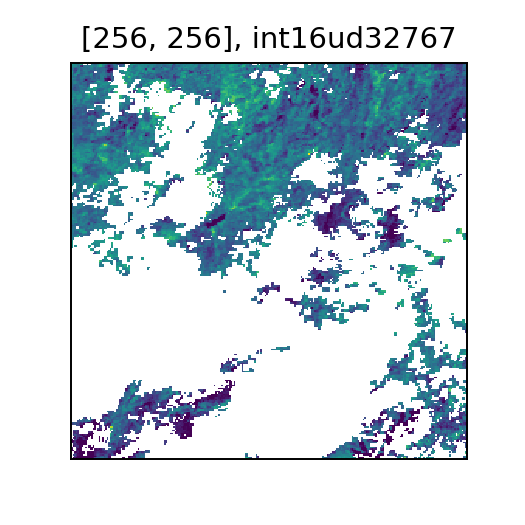

In [2]:
import pyrasterframes.rf_ipython

def scene(band):
    b = str(band).zfill(2) # converts int 2 to '02'
    return 'https://modis-pds.s3.amazonaws.com/MCD43A4.006/11/08/2019059/' \
             'MCD43A4.A2019059.h11v08.006.2019072203257_B{}.TIF'.format(b)
spark_df = spark.read.raster(scene(2), tile_dimensions=(256, 256))
tile = spark_df.select(rf_tile('proj_raster').alias('tile')).first()['tile']
tile

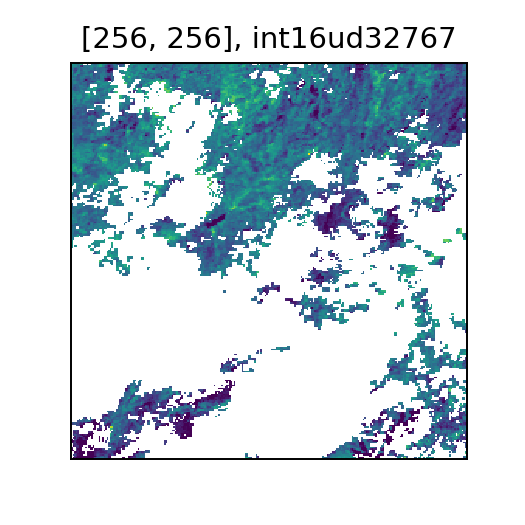

In [3]:
display(tile) # IPython.display function


## DataFrame Samples

Within an IPython or Jupyter interpreter, a Spark and Pandas DataFrames containing a column of _tiles_ will be rendered as the samples discussed above. Simply import the `rf_ipython` submodule to enable enhanced HTML rendering of these DataFrame types.



DataFrame[tile: udt, xmin: double, ymin: double, xmax: double, ymax: double]
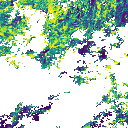
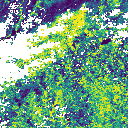
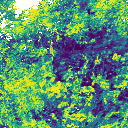
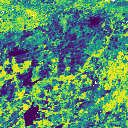
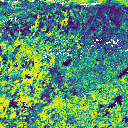

In [4]:
samples = spark_df \
    .select(
        rf_extent('proj_raster').alias('extent'),
        rf_tile('proj_raster').alias('tile'),
    )\
    .select('tile', 'extent.*') 
samples


## Rendering Samples with Color

By default the IPython visualizations use the Viridis color map for each single channel tile. There are other options for reasoning about how color should be applied in the results.


### Color Composites

Rendering three different bands of imagery together is called a _color composite_. The bands selected are mapped to the red, green, and blue channels of the resulting display. If the bands chosen are red, green, and blue, the composite is called a true-color composite. Otherwise it is a false-color composite.

Using the @ref:[`rf_rgb_composite`](reference.md#rf-rgb-composite) function, we will compute a three band PNG image as a `bytearray`. The resulting `bytearray` will be displayed as an image in either a Spark or pandas DataFrame display if `rf_ipython` has been imported.



DataFrame[png: binary]
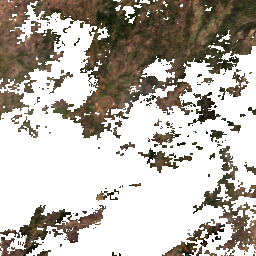
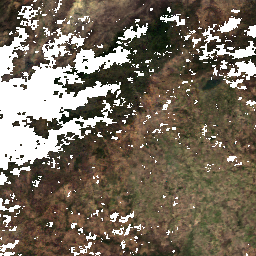
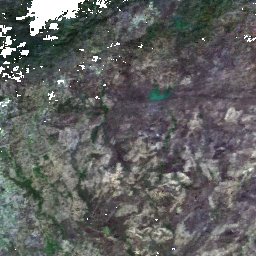
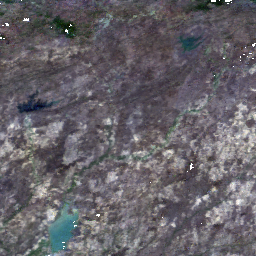
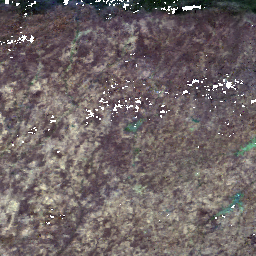

In [5]:
# Select red, green, and blue, respectively
composite_df = spark.read.raster([[scene(1), scene(4), scene(3)]],
                                 tile_dimensions=(256, 256))
composite_df = composite_df.withColumn('png',
                    rf_render_png('proj_raster_0', 'proj_raster_1', 'proj_raster_2'))
composite_df.select('png')



Alternatively the `bytearray` result can be displayed with [`pillow`](https://pillow.readthedocs.io/en/stable/).



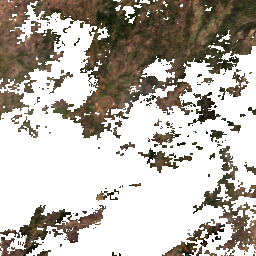

In [6]:
import io
from PIL.Image import open as PIL_open
png_bytearray = composite_df.first()['png']
pil_image = PIL_open(io.BytesIO(png_bytearray))
pil_image

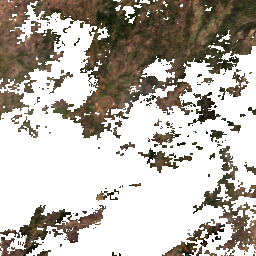

In [7]:
display(pil_image)


### Custom Color Map

You can also apply a different color map to a single-channel Tile using the @ref[`rf_render_color_ramp_png`](reference.md#rf-render-color-ramp-png) function. See the function documentation for information about the available color maps.



DataFrame[rf_render_png(tile): binary]
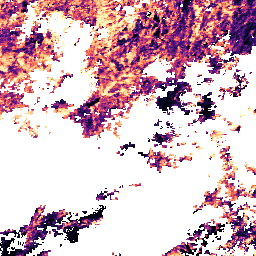
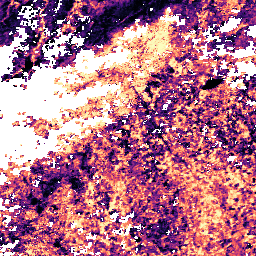
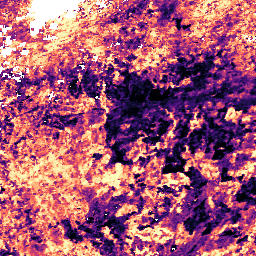
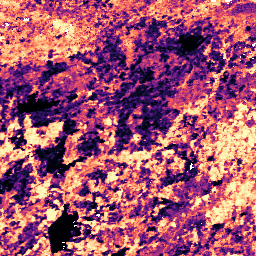
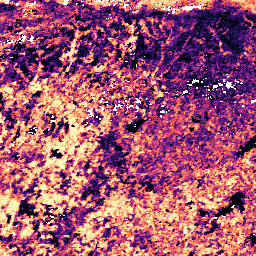

In [8]:
samples.select(rf_render_color_ramp_png('tile', 'Magma'))



## GeoTIFFs

GeoTIFF is one of the most common file formats for spatial data, providing flexibility in data encoding, representation, and storage. RasterFrames provides a specialized Spark DataFrame writer for rendering a RasterFrame to a GeoTIFF.

One downside to GeoTIFF is that it is not a big data native format. To create a GeoTIFF, all the data to be encoded has to be in the memory of one computer (in Spark parlance, this is a "collect"), limiting it's maximum size substantially compared to that of a full cluster environment. When rendering GeoTIFFs in RasterFrames, you must either specify the dimensions of the output raster, or deliberately limit the size of the collected data.

Fortunately, we can use the cluster computing capability to downsample the data into a more manageable size. For sake of example, let's render an overview of a scene's red band as a small raster, reprojecting it to latitude and longitude coordinates on the [WGS84](https://en.wikipedia.org/wiki/World_Geodetic_System) reference ellipsoid (aka [EPSG:4326](https://spatialreference.org/ref/epsg/4326/)).



In [9]:
outfile = os.path.join('/tmp', 'geotiff-overview.tif')
spark_df.write.geotiff(outfile, crs='EPSG:4326', raster_dimensions=(256, 256))


We can view the written file with `rasterio`:



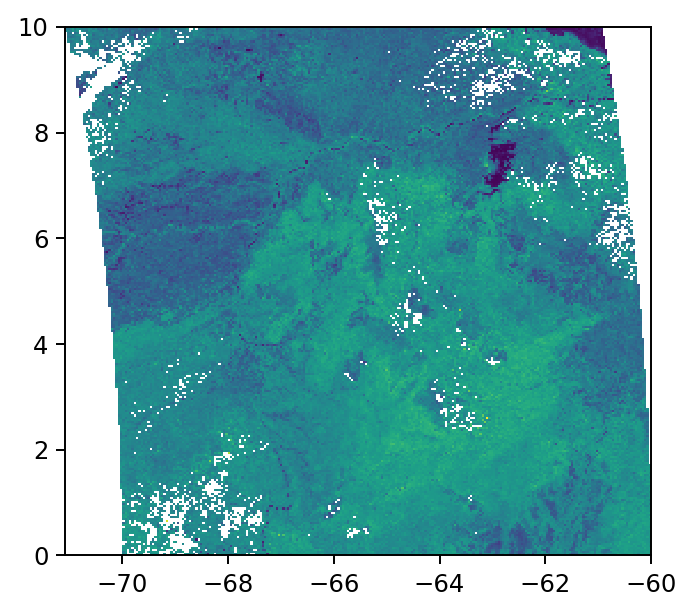

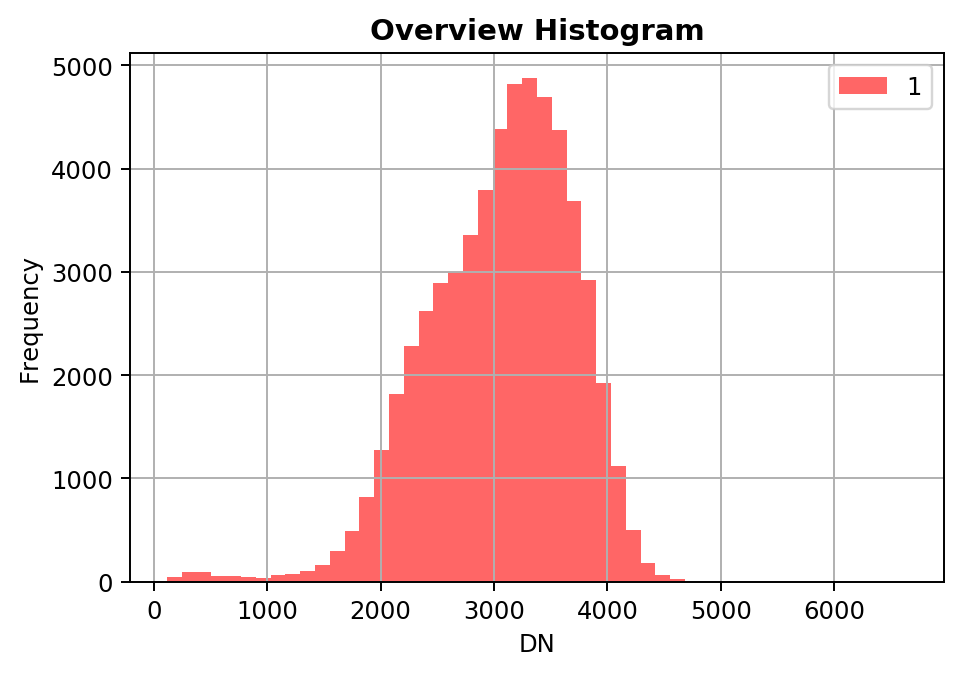

In [10]:
import rasterio
from rasterio.plot import show, show_hist

with rasterio.open(outfile) as src:
    # View raster
    show(src, adjust='linear')
    # View data distribution
    show_hist(src, bins=50, lw=0.0, stacked=False, alpha=0.6,
        histtype='stepfilled', title="Overview Histogram")


If there are many _tile_ or projected raster columns in the DataFrame, the GeoTIFF writer will write each one as a separate band in the file. Each band in the output will be tagged the input column names for reference.



In [11]:
os.remove(outfile)


### Downsampling

If no `raster_dimensions` column is specified the DataFrame contents are written at full resolution. As shown in the example above, you can also specify the size of the output GeoTIFF. Bilinear resampling is used. 


### Color Composites

If the DataFrame has three or four tile columns, the GeoTIFF is written with the `ColorInterp` tags on the [bands](https://gdal.org/user/raster_data_model.html?highlight=color%20interpretation#raster-band) to indicate red, green, blue, and optionally alpha. Use a `select` statement to ensure your intended color compositing. Note that any other number of tile columns will result in a greyscale interpretation. 


## Overview Rasters

In cases where writing and reading to/from a GeoTIFF isn't convenient, RasterFrames provides the @ref:[`rf_agg_overview_raster`](reference.md#rf-agg-overview-raster) aggregate function, where you can construct a single raster (rendered as a tile) downsampled from all or a subset of the DataFrame. This allows you to effectively construct the same operations the GeoTIFF writer performs, but without the file I/O. 

The `rf_agg_overview_raster` function will reproject data to the commonly used ["web mercator"](https://en.wikipedia.org/wiki/Web_Mercator_projection) CRS. You must specify an "Area of Interest" (AOI) in web mercator.  You can use @ref:[`rf_agg_reprojected_extent`](reference.md#rf-agg-reprojected-extent) to compute the extent of a DataFrame in any CRS or mix of CRSs.



Extent(-7912574.135382183, -7.081154551613622E-10, -6679169.446996604, 1118889.9747567875)


`ov` is of type <class 'pyrasterframes.rf_types.Tile'>


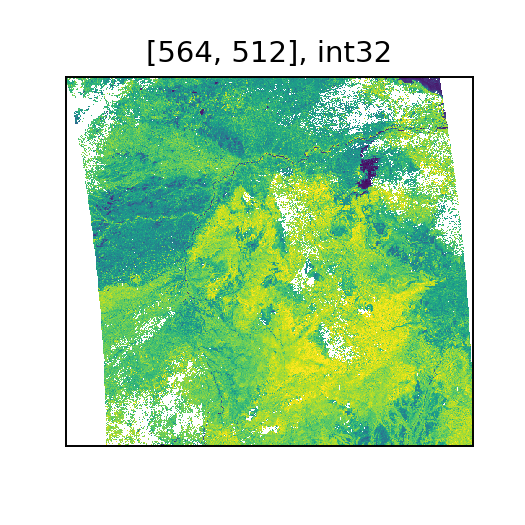

In [12]:
from pyrasterframes.rf_types import Extent
wm_extent = spark_df.agg(
                  rf_agg_reprojected_extent(rf_extent('proj_raster'), rf_crs('proj_raster'), 'EPSG:3857')
                  ).first()[0]
aoi = Extent.from_row(wm_extent)
print(aoi)
aspect = aoi.width / aoi.height

ov = spark_df.agg(
           rf_agg_overview_raster('proj_raster', int(512 * aspect), 512, aoi)
           ).first()[0]
print("`ov` is of type", type(ov))
ov

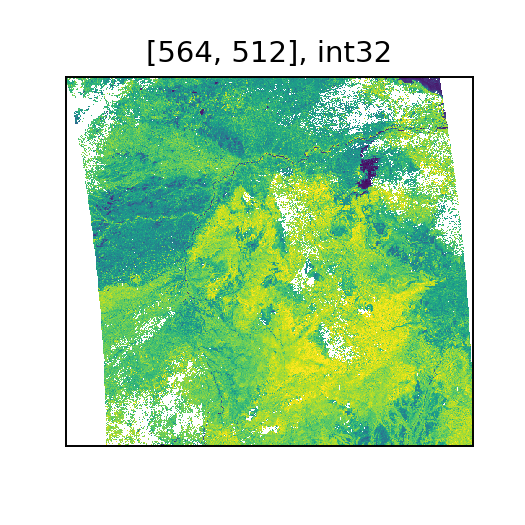

In [13]:
display(ov)


## GeoTrellis Layers

[GeoTrellis][GeoTrellis] is one of the key libraries upon which RasterFrames is built. It provides a Scala language API for working with geospatial raster data.  GeoTrellis defines a [tile layer storage](https://geotrellis.readthedocs.io/en/latest/guide/tile-backends.html) format for persisting imagery mosaics. RasterFrames can write data from a `RasterFrameLayer` into a [GeoTrellis Layer](https://geotrellis.readthedocs.io/en/latest/guide/tile-backends.html). RasterFrames provides a `geotrellis` DataSource that supports both @ref:[reading](raster-read.md#geotrellis-layers) and @ref:[writing](raster-write.md#geotrellis-layers) GeoTrellis layers.

> An example is forthcoming. In the mean time referencing the [`GeoTrellisDataSourceSpec` test code](https://github.com/locationtech/rasterframes/blob/develop/datasource/src/test/scala/org/locationtech/rasterframes/datasource/geotrellis/GeoTrellisDataSourceSpec.scala) may help.

## Parquet

You can write a RasterFrame to the [Apache Parquet][Parquet] format. This format is designed to efficiently persist and query columnar data in distributed file system, such as HDFS. It also provides benefits when working in single node (or "local") mode, such as tailoring organization for defined query patterns.



In [14]:
spark_df.withColumn('exp', rf_expm1('proj_raster')) \
    .write.mode('append').parquet('hdfs:///rf-user/sample.pq')


[GeoTrellis]: https://geotrellis.readthedocs.io/en/latest/
[Parquet]: https://spark.apache.org/docs/latest/sql-data-sources-parquet.html
